# ICESpark-EarthCube-2022-Annual-Meeting

ICESpark in Action: Analyzing Large-scale Arctic Observations Using an Open-source Big Data Platform


## Authors

* Author1 = {"name": "Jia Yu", "affiliation": "Washington State University", "email": "jia.yu1@wsu.edu"}
* Author2 = {"name": "Yiqun Xie", "affiliation": "University of Maryland", "email": "xie@umd.edu"}
* Author3 = {"name": "Kyle Duncan", "affiliation": "University of Maryland", "email": "kduncan@umd.edu"}
* Author4 = {"name": "Sinead Louise Farrell", "affiliation": "University of Maryland", "email": "sineadf@umd.edu"}

## Table of Contents

1. [ICESpark-EarthCube-2022-Annual-Meeting](#ICESpark-EarthCube-2022-Annual-Meeting)
2. [Setup](#Setup)
3. [Data import](#Data-import)
4. [Demo 1: Find the crossings between ICESat-2 orbits and SODA moorings ](#Demo-1:-Find-the-crossings-between-ICESat-2-orbits-and-SODA-moorings)
5. [Demo 2:  Find the crossing between ICESat-2 orbits and Sentinel-2 and WorldView-3 images](#Demo-2:--Find-the-crossing-between-ICESat-2-orbits-and-Sentinel-2-and-WorldView-3-images)


## Purpose

The Arctic climate system is undergoing rapid change with rising air and sea surface temperatures, accompanied by declines in Arctic glacial ice and sea ice as well as loss of snow cover on land. The combined increase in global air temperature and ice-sheet mass loss is driving sea level rise around the globe. As the Arctic region is largely inaccessible to traditional observation techniques, satellite remote sensing systems play a key role in monitoring the essential climate variables. However, the unprecedented volume and variety of geospatial big data collected by new satellite sensors have reached far beyond the capacity of computing platforms accessible to most geoscientists. ICESpark is an open-source distributed platform that can combine local commodity computers into a powerful environment that is ready for geospatial big data (GeoBD). Built on Apache Sedona, ICESpark comprises a set of off-the-shelf data integration tools and analytical functions to make sense of large-scale arctic observations.

## Technical contributions

We plan to demonstrate ICESpark through a Python Jupyter notebook running on top of a cluster of commodity computers to let the audience experience the scalability and interactivity provided by the tool. In this notebook, we demonstrate three case studies to illustrate how ICESpark may help geoscientists quickly find temporally and/or spatially coincident data across heterogenous arctic observation data. This task is typically required to validate the accuracy of new remote sensing data products, or for cross comparison of complementary polar climate variables.

## Results


* The first case study includes Stratified Ocean Dynamics of the Arctic (SODA) moorings and ICESat-2 reference ground tracks (RGTs), where the goal is to find all ICESat-2 orbits falling within a 50 km search radius around the mooring sites.
* The second case study integrates Sentinel-2 and WorldView-3 imagery to discover the spatial overlaps between ICESat-2 RGTs and tiles from these high-resolution imagery datasets.
* The last case study compares the aforementioned lCESat 2 orbits (RGTs) against the MOSAiC expedition cruise master track data. The goal of this study is to find the spatio-temporal overalps between ICESat-Z orbits and a 50KM search radius around each reported cruise location.


## Funding

* Award1 = {"agency": "US National Science Foundation", "award_code": "2126449", "award_URL": "https://www.nsf.gov/awardsearch/showAward?AWD_ID=2126449&HistoricalAwards=false"}

* Award2 = {"agency": "US National Science Foundation", "award_code": "2126474", "award_URL": "https://www.nsf.gov/awardsearch/showAward?AWD_ID=2126474&HistoricalAwards=false"}


## Keywords

keywords=["arctic observation", "big data", "cluster computing"]


# Setup

## Library import

In [132]:
## Import local library
import os

## Import GeoPandas
import geopandas as gpd

## Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col

## Import Apache Sedona
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils.adapter import Adapter

## Initialize the cluster environment

In [133]:
spark = SparkSession. \
    builder. \
    appName('appName'). \
    master('local[*]'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
    getOrCreate()

## Register geospatial data support

In [134]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")

22/04/20 18:13:24 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.geom.Geometry, which is already registered.
22/04/20 18:13:24 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.index.SpatialIndex, which is already registered.
22/04/20 18:13:24 WARN SimpleFunctionRegistry: The function st_pointfromtext replaced a previously registered function.
22/04/20 18:13:24 WARN SimpleFunctionRegistry: The function st_polygonfromtext replaced a previously registered function.
22/04/20 18:13:24 WARN SimpleFunctionRegistry: The function st_linestringfromtext replaced a previously registered function.
22/04/20 18:13:24 WARN SimpleFunctionRegistry: The function st_geomfromtext replaced a previously registered function.
22/04/20 18:13:24 WARN SimpleFunctionRegistry: The function st_geomfromwkt replaced a previously registered function.
22/04/20 18:13:24 WARN SimpleFunctionRegistry: The function st_geomfromwkb replaced a previously registered function.
22/04/20 18:13:

# Data import

## Load ICE_SAT2 orbits into Spark
Files are originally in KML. They are converted to a single WKT file using GDAL ogr2ogr command.

The converted dataset contains 13704 orbits and has 2.6GB in size. The notebook only takes a sample of 499 orbits because of the limited resource provided in Binder environment. In addition, GitHub only allows max 100MB per file.

Filename example: IS2_RGT_0702_cycle3_14-May-2019.kml.csv

In [135]:
spark.read.format("csv").\
    option("delimiter", ",").\
    option("header", "true").\
    load("data/IS2_RGTs_aggr_data_timestamp-head500.csv").repartition(10).\
    createOrReplaceTempView("is2_df_raw")


## Create DataFrame with a Geometry column

In [136]:
spark.sql("select ST_FlipCoordinates(ST_GeomFromWKT(WKT)) as orbit, Name, altitudeMode, tessellate, extrude, visibility, filename from is2_df_raw").\
    cache().\
    createOrReplaceTempView("is2_df")

## Show the schema of the table
spark.table("is2_df").show(2)

## Show the names of the orbits
spark.table("is2_df").select("filename").show(100, truncate = False)

## Print the count. The total count should be 499
print(spark.table("is2_df").count())

+--------------------+-----+-------------+----------+-------+----------+--------------------+
|               orbit| Name| altitudeMode|tessellate|extrude|visibility|            filename|
+--------------------+-----+-------------+----------+-------+----------+--------------------+
|LINESTRING (0.056...|RGT 3|clampToGround|        -1|      0|         1|IS2_RGT_0003_cycl...|
|LINESTRING (0.027...|RGT 1|clampToGround|        -1|      0|         1|IS2_RGT_0001_cycl...|
+--------------------+-----+-------------+----------+-------+----------+--------------------+
only showing top 2 rows

+----------------------------------------+
|filename                                |
+----------------------------------------+
|IS2_RGT_0003_cycle6_26-Dec-2019.kml.csv |
|IS2_RGT_0001_cycle5_26-Sep-2019.kml.csv |
|IS2_RGT_0006_cycle10_24-Dec-2020.kml.csv|
|IS2_RGT_0004_cycle5_27-Sep-2019.kml.csv |
|IS2_RGT_0003_cycle7_26-Mar-2020.kml.csv |
|IS2_RGT_0007_cycle7_26-Mar-2020.kml.csv |
|IS2_RGT_0008_cycle11_25

22/04/20 18:13:24 WARN CacheManager: Asked to cache already cached data.


## Read a country shapefile as the base map, for visualization purpose

In [137]:
countries = ShapefileReader.readToGeometryRDD(sc, "data/ne_50m_admin_0_countries_lakes")
countries_df = Adapter.toDf(countries, spark).select("geometry", "NAME_EN")
countries_df.show(2)

+--------------------+--------------------+
|            geometry|             NAME_EN|
+--------------------+--------------------+
|MULTIPOLYGON (((3...|Zimbabwe         ...|
|MULTIPOLYGON (((3...|Zambia           ...|
+--------------------+--------------------+
only showing top 2 rows



# Demo 1: Find the crossings between ICESat-2 orbits and SODA moorings 

We have 3 Stratified Ocean Dynamics of the Arctic (SODA) moorings sites at the following locations:


SODA-A: (73.00043, -148.33627)

SODA-B: (75.46388, -145.63685)

SODA-C: (77.73677, -139.14153)

## Find the crossings around three SODA objects, each of which has a 100KM buffer area, using ST_Buffer

IceSat2 data needs to be converted from WGS84 (epsg:4326) CRS to meter-based epsg:4087 (WGS 84 / World Equidistant Cylindrical) using Sedona's ST_Transform

In [138]:
result_df1 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(ST_Buffer(ST_Transform(ST_POINT (73.00043,-148.33627), \'epsg:4326\',\'epsg:4087\'), 100000), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\'))')
result_df1.show(2)
print('SODA-A crosses: ', result_df1.count())

result_df2 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(ST_Buffer(ST_Transform(ST_POINT (75.46388,-145.63685), \'epsg:4326\',\'epsg:4087\'), 100000), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\'))')
print('SODA-B crosses: ', result_df2.count())

result_df3 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(ST_Buffer(ST_Transform(ST_POINT (77.73677, -139.14153), \'epsg:4326\',\'epsg:4087\'), 100000), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\'))')
print('SODA-C crosses: ', result_df3.count())


+--------------------+------+-------------+----------+-------+----------+--------------------+
|               orbit|  Name| altitudeMode|tessellate|extrude|visibility|            filename|
+--------------------+------+-------------+----------+-------+----------+--------------------+
|LINESTRING (0.025...|RGT 22|clampToGround|        -1|      0|         1|IS2_RGT_0022_cycl...|
|LINESTRING (0.025...|RGT 22|clampToGround|        -1|      0|         1|IS2_RGT_0022_cycl...|
+--------------------+------+-------------+----------+-------+----------+--------------------+
only showing top 2 rows

SODA-A crosses:  10
SODA-B crosses:  0
SODA-C crosses:  10


## Find orbits in Year 2019 in the SODA-C result

In [139]:
result_df3_sorted = result_df3.filter("filename LIKE \'%2019%\'").sort(col('filename').asc())
result_df3_sorted.select('filename').show(truncate = False)

+---------------------------------------+
|filename                               |
+---------------------------------------+
|IS2_RGT_0008_cycle3_29-Mar-2019.kml.csv|
|IS2_RGT_0008_cycle5_27-Sep-2019.kml.csv|
|IS2_RGT_0008_cycle6_27-Dec-2019.kml.csv|
+---------------------------------------+



## Visualize crossings on SODA-C using GeoPandas

### Put SODA-C into a DF and convert it to 100KM circle

In [140]:
soda_list = ["POINT (73.00043 -148.33627)", "POINT (75.46388 -145.63685)", "POINT (77.73677 -139.14153)"]
# soda_list = ["POINT (77.73677 -139.14153)"]
soda_df = spark.createDataFrame(soda_list,StringType())
# Convert to epsg:4087 meter-based CRS
soda_df = soda_df.selectExpr('ST_Transform(ST_GeomFromWKT(value), \'epsg:4326\',\'epsg:3413\') as is2_df')
soda_df.show()
# Create circles using 50KM
soda_df = soda_df.selectExpr('ST_Buffer(is2_df, 100000) as is2_df')
# Convert to epsg:4326 WGS84
soda_df = soda_df.selectExpr('ST_FlipCoordinates(ST_Transform(is2_df, \'epsg:3413\',\'epsg:4326\')) as is2_df')
# soda_df.show()

+--------------------+
|              is2_df|
+--------------------+
|POINT (-1804587.9...|
|POINT (-1555620.5...|
|POINT (-1329850.8...|
+--------------------+



### Convert SODA-C result DataFrame to GeoPandas DataFrame

In [141]:
country_gpd = gpd.GeoDataFrame(countries_df.toPandas(), geometry="geometry")
soda_gpd = gpd.GeoDataFrame(soda_df.toPandas(), geometry="is2_df")
orbit_gpd = gpd.GeoDataFrame(result_df3.selectExpr('ST_FlipCoordinates(orbit) as orbit').toPandas(), geometry="orbit")

/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/geopandas/geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


### Plot the maps

You can uncomment different base XY to change the view of the map

/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/li

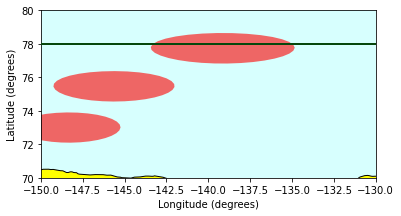

In [142]:
base = country_gpd.plot(color='yellow', edgecolor='black', zorder=1)
base.set_facecolor('#d7fffe')
# SODA-A Close-up view
#base.set_xlim(-151, -146)
#base.set_ylim(71, 75)
# SODA-B Close-up view
#base.set_xlim(-147.5, -143.5)
#base.set_ylim(74, 77)
# SODA-C Close-up view
base.set_xlim(-150, -130)
base.set_ylim(70, 80)
# SODA-ABC Close-up view
# base.set_xlim(-160, -130)
# base.set_ylim(60, 90)
# Global view
# base.set_xlim(-180, 180)
# base.set_ylim(-90, 90)
base.set_xlabel('Longitude (degrees)')
base.set_ylabel('Latitude (degrees)')
orbit = orbit_gpd.plot(ax=base, color='#06470c', zorder=3)
soda = soda_gpd.plot(ax=orbit, color='red', alpha=0.6, zorder=2)

# Demo 2:  Find the crossing between ICESat-2 orbits and Sentinel-2 and WorldView-3 images

**Two Sentinel-2 image bounding boxes (lat, lon format)**

S-2 image from June 22, 2019:
```
UL: 82.852919, -63.001439
LL: 81.869306, -63.001267
UR: 82.785942, -55.145842
LR: 81.810456, -56.080844
```

Polygon format (UL - LL - LR - UR - UL): 82.852919, -63.001439, 81.869306, -63.001267, 81.810456, -56.080844, 82.785942, -55.145842, 82.852919, -63.001439

S-2 image from September 3, 2019:
```
UL: 79.232286, -121.801758
LL: 78.251639, -121.405181
UR: 79.268856, -116.530467
LR: 78.285072, -116.569403
```

Polygon format (UL - LL - LR - UR - UL): 79.232286, -121.801758, 78.251639, -121.405181, 78.285072, -116.569403, 79.268856, -116.530467, 79.232286, -121.801758

**WorldView image bounding boxes (lat, lon format)**

WV-3 image from April 10, 2019
```
UL: 79.76066207, -114.09955772
LL: 79.62275657, -114.06853064
UR: 79.83858880, -112.31487793
LR: 79.69303180, -112.34933739
```

Polygon format (UL - LL - LR - UR - UL): 79.76066207, -114.09955772, 79.62275657, -114.06853064, 79.69303180, -112.34933739, 79.83858880, -112.31487793, 79.76066207, -114.09955772

WV-2 image from April 10, 2019
```
UL: 80.0576610499, -110.56248745
LL: 79.9244458799, -110.56242819
UR: 80.044587680, -109.42456569
LR: 79.9092631399, -109.42423191
```

Polygon format (UL - LL - LR - UR - UL): 80.0576610499, -110.56248745, 79.9244458799, -110.56242819, 79.9092631399, -109.42423191, 80.044587680, -109.42456569, 80.0576610499, -110.56248745

WV-2 image from June 25, 2020
```
UL: 84.04474275, -60.80835633
LL: 83.90936693, -60.7855143
UR: 84.04404486, -59.21133579
LR: 83.90966186, -59.23332056
```

Polygon format (UL - LL - LR - UR - UL): 84.04474275, -60.80835633, 83.90936693, -60.7855143, 83.90966186, -59.23332056, 84.04404486, -59.21133579, 84.04474275, -60.80835633

## Check if orbits intersect S-2 and/or WorldView bounding boxes

In [143]:
# modified projection

result_df1 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'82.852919, -63.001439,81.869306, -63.001267, 81.810456, -56.080844, 82.785942, -55.145842, 82.852919, -63.001439\',\',\'))')
result_df1.select("filename").show(truncate = False)
print('Sentinel-2 A number of crosses: ', result_df1.count())

result_df2 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'79.232286, -121.801758, 78.251639, -121.405181, 78.285072, -116.569403, 79.268856, -116.530467, 79.232286, -121.801758\',\',\'))')
print('Sentinel-2 B number of crosses: ', result_df2.count())

result_df3 = spark.sql('SELECT * '
                      'FROM is2_df '
                      'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'79.76066207, -114.09955772, 79.62275657, -114.06853064, 79.69303180, -112.34933739, 79.83858880, -112.31487793, 79.76066207, -114.09955772\',\',\'))')
print('WorldView A number of crosses: ', result_df3.count())

result_df4 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'80.0576610499, -110.56248745, 79.9244458799, -110.56242819, 79.9092631399, -109.42423191, 80.044587680, -109.42456569, 80.0576610499, -110.56248745\',\',\'))')
print('WorldView B number of crosses: ', result_df4.count())

result_df5 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(orbit, ST_PolygonFromText (\'84.04474275, -60.80835633, 83.90936693, -60.7855143, 83.90966186, -59.23332056, 84.04404486, -59.21133579, 84.04474275, -60.80835633\',\',\'))')
print('WorldView C number of crosses: ', result_df5.count())

+----------------------------------------+
|filename                                |
+----------------------------------------+
|IS2_RGT_0018_cycle2_29-Dec-2018.kml.csv |
|IS2_RGT_0018_cycle5_28-Sep-2019.kml.csv |
|IS2_RGT_0023_cycle2_29-Dec-2018.kml.csv |
|IS2_RGT_0033_cycle10_26-Dec-2020.kml.csv|
|IS2_RGT_0033_cycle5_29-Sep-2019.kml.csv |
|IS2_RGT_0042_cycle10_26-Dec-2020.kml.csv|
|IS2_RGT_0018_cycle11_25-Mar-2021.kml.csv|
|IS2_RGT_0023_cycle8_26-Jun-2020.kml.csv |
|IS2_RGT_0033_cycle8_27-Jun-2020.kml.csv |
|IS2_RGT_0033_30-Dec-2018.kml.csv        |
|IS2_RGT_0018_cycle3_30-Mar-2019.kml.csv |
|IS2_RGT_0023_cycle6_28-Dec-2019.kml.csv |
|IS2_RGT_0033_cycle7_28-Mar-2020.kml.csv |
|IS2_RGT_0042_cycle6_29-Dec-2019.kml.csv |
|IS2_RGT_0018_cycle9_25-Sep-2020.kml.csv |
|IS2_RGT_0033_cycle2_30-Dec-2018.kml.csv |
|IS2_RGT_0033_cycle11_26-Mar-2021.kml.csv|
|IS2_RGT_0042_cycle11_27-Mar-2021.kml.csv|
|IS2_RGT_0042_cycle9_26-Sep-2020.kml.csv |
|IS2_RGT_0018_cycle7_27-Mar-2020.kml.csv |
+----------

## Find orbits in Year 2019 in the S-2 A result

In [144]:
result_df1.filter('filename LIKE \'%2019%\'').select("filename").show(result_df1.count(), truncate = False)

+---------------------------------------+
|filename                               |
+---------------------------------------+
|IS2_RGT_0018_cycle5_28-Sep-2019.kml.csv|
|IS2_RGT_0033_cycle5_29-Sep-2019.kml.csv|
|IS2_RGT_0018_cycle3_30-Mar-2019.kml.csv|
|IS2_RGT_0023_cycle6_28-Dec-2019.kml.csv|
|IS2_RGT_0042_cycle6_29-Dec-2019.kml.csv|
|IS2_RGT_0033_cycle6_28-Dec-2019.kml.csv|
|IS2_RGT_0018_cycle6_27-Dec-2019.kml.csv|
|IS2_RGT_0033_cycle3_31-Mar-2019.kml.csv|
|IS2_RGT_0042_cycle3_01-Apr-2019.kml.csv|
|IS2_RGT_0042_cycle5_29-Sep-2019.kml.csv|
|IS2_RGT_0023_cycle5_28-Sep-2019.kml.csv|
|IS2_RGT_0023_cycle3_30-Mar-2019.kml.csv|
+---------------------------------------+



## Visualize crossings on S-2 A using GeoPandas 

### Put S-2 A into a DataFrame

You can uncomment other examples as well

In [145]:
s2_a = spark.sql('SELECT ST_FlipCoordinates(ST_PolygonFromText (\'82.852919, -63.001439, 81.869306, -63.001267, 81.810456, -56.080844, 82.785942, -55.145842, 82.852919, -63.001439\',\',\')) as s2a')
s2_a.show()
#s2_a = spark.sql('SELECT ST_FlipCoordinates(ST_PolygonFromText (\'82.852919, -63.001439, 81.869306, -63.001267, 81.810456, -56.080844, 82.785942, -55.145842, 82.852919, -63.001439\',\',\')) as s2a')
#s2_b = spark.sql('SELECT ST_FlipCoordinates(ST_PolygonFromText (\'79.232286, -121.801758, 78.251639, -121.405181, 78.285072, -116.569403, 79.268856, -116.530467, 79.232286, -121.801758\',\',\')) as s2b')
# wv_a = spark.sql('SELECT ST_FlipCoordinates(ST_PolygonFromText (\'79.76066207, -114.09955772, 79.62275657, -114.06853064, 79.69303180, -112.34933739, 79.83858880, -112.31487793, 79.76066207, -114.09955772\',\',\')) as wva')
#s2_a.show()
#s2_b.show()
#wv_a.show()

+--------------------+
|                 s2a|
+--------------------+
|POLYGON ((-63.001...|
+--------------------+



### Convert result DataFrame to GeoPandas DataFrame

In [146]:
country_gpd = gpd.GeoDataFrame(countries_df.toPandas(), geometry="geometry")
## Separate lines for each example
s2_gpd = gpd.GeoDataFrame(s2_a.toPandas(), geometry="s2a")
#s2_gpd = gpd.GeoDataFrame(s2_b.toPandas(), geometry="s2b")
# wv_gpd = gpd.GeoDataFrame(wv_a.toPandas(), geometry="wva")
orbit_gpd = gpd.GeoDataFrame(result_df1.selectExpr('ST_FlipCoordinates(orbit) as orbit').toPandas(), geometry="orbit")
#orbit_gpd = gpd.GeoDataFrame(result_df2.selectExpr('ST_FlipCoordinates(orbit) as orbit').toPandas(), geometry="orbit")
# orbit_gpd = gpd.GeoDataFrame(result_df3.selectExpr('ST_FlipCoordinates(orbit) as orbit').toPandas(), geometry="orbit")

/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/geopandas/geodataframe.py:35: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)


### Plot the maps
You can uncomment different base XY to change the view of the map

/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/li

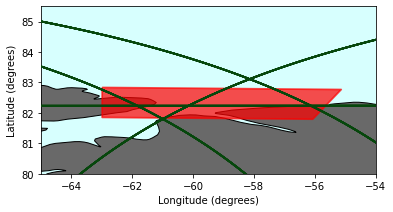

In [147]:
base = country_gpd.plot(color='dimgray', edgecolor='black', zorder=1)
base.set_facecolor('#d7fffe')
# Sentinel-2 A view
base.set_xlim(-65, -54)
base.set_ylim(80, 85.5)
# Sentinel-2 B view
#base.set_xlim(-125, -113)
#base.set_ylim(72, 80)
# WorldView A view
# base.set_xlim(-115, -111)
# base.set_ylim(78, 81)
# Global view
#base.set_xlim(-180, 180)
#base.set_ylim(-90, 90)
base.set_xlabel('Longitude (degrees)')
base.set_ylabel('Latitude (degrees)')
orbit = orbit_gpd.plot(ax=base, color='#06470c', linewidth=1.75, label='IS2 RGT 1298 & 1307', zorder=3)
s2 = s2_gpd.plot(ax=orbit, color='red', alpha=0.7, edgecolor='red', linewidth=1.75, zorder=2)
# wv = wv_gpd.plot(ax=orbit, color='red', alpha=0.7, edgecolor='red', linewidth=1.75, label='WV-2 Image', zorder=2)
#plt.legend(loc='upper right', framealpha=1)
#plt.title('June 22, 2019 Sentinel-2 and IS-2 crossing')
#plt.show()